# Lookup Table Interpolation
We use a lookup table (LUT) to estimate the value of T1 from an MP2RAGE sequence.

In [1]:
import os
import json
import nibabel as nib
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error
import t1_mapping

# Change plot style
plt.style.use('Solarize_Light2')

# Load data
We load the given data from an example MP2RAGE sequence.

In [2]:
# Load dataset paths
subject = '334264'
scan = '401-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE'
scan_num = '401'
scan_times = ['1010', '3310']
dataset_path = '/nfs/masi/saundam1/outputs/mp2rage_converted_v2023/'
subject_path = os.path.join(dataset_path, subject, scan)

# Load NIFTI files
inv1_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[0]}.nii'))
inv1_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[0]}.nii'))
inv2_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[1]}.nii'))
inv2_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[1]}.nii'))

# Load JSON
inv1_json_path = os.path.join(subject_path, f'{scan_num}_t{scan_times[0]}.json')
inv2_json_path = os.path.join(subject_path, f'{scan_num}_t{scan_times[1]}.json')
with open(inv1_json_path, 'r') as f1, open(inv2_json_path, 'r') as f2:
    inv1_json = json.load(f1)
    inv2_json = json.load(f2)

# Load data from NIFTI
inv1_real_data = inv1_real.get_fdata()
inv1_imag_data = inv1_imag.get_fdata()
inv2_real_data = inv2_real.get_fdata()
inv2_imag_data = inv2_imag.get_fdata()

# Create combined complex data
inv1_data = inv1_real_data + 1j*inv1_imag_data
inv2_data = inv2_real_data + 1j*inv2_imag_data

## Plot T1-weighted image
Now, we plot the T1-weighted image calculated from the gradient echo readouts.

Text(0.5, 1.0, 'T1-Weighted Image')

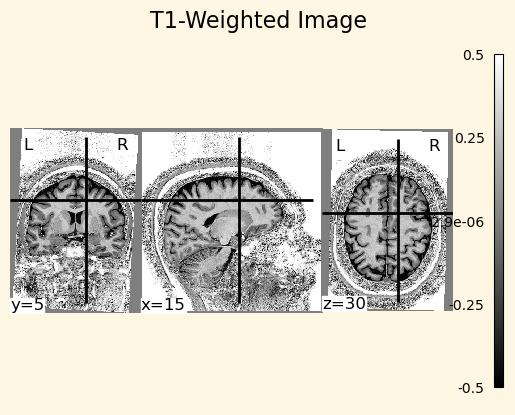

In [4]:
# Calculate MP2RAGE image
t1w = t1_mapping.utils.mp2rage_t1w(inv1_data, inv2_data)
t1w_nifti = nib.nifti2.Nifti2Image(t1w, inv1_real.affine)

# Plot T1w image
fig, ax = plt.subplots()
plotting.plot_img(t1w_nifti, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)
ax.set_title('T1-Weighted Image')

# Create LUT
Next, we calculate the values for the LUT given the provided parameters and an estimate of the t-values.

In [ ]:
# Range of values for t
t_estimate = np.linspace(1, 20, 100).reshape(100,1)

# Calculate what values would be produced with the range for t
values = f(t_estimate, A, B, C).reshape(100,1)
print(f'Range of values for LUT: {np.min(values)}, {np.max(values)}')

# Create LUT
LUT = np.hstack((values, t_estimate))

# Sort LUT so values are in numerical order
LUT = LUT[LUT[:, 0].argsort()]

Range of values for LUT: 4.122307244877108e-08, 0.32402713683194273


# Calculate $t$ map using LUT
Finally, we can calculate values for $t$ by interpolating between the values on our LUT.

RMSE=0.10328411904365967


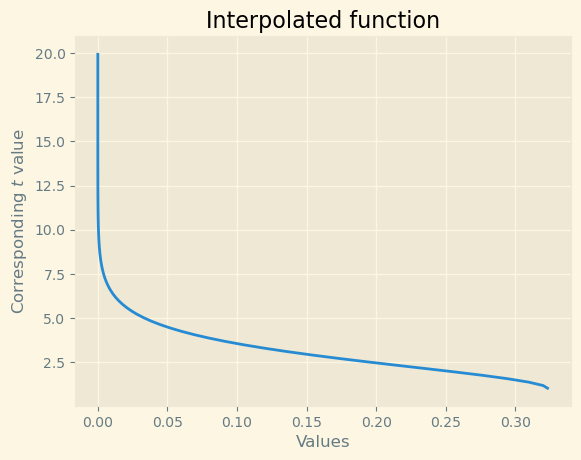

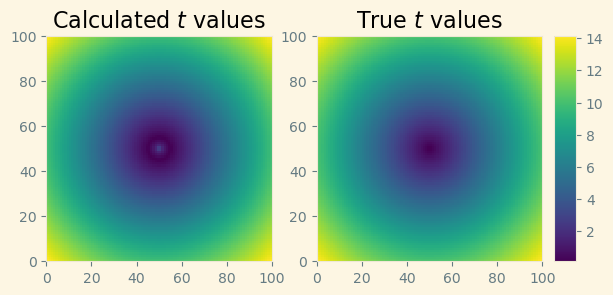

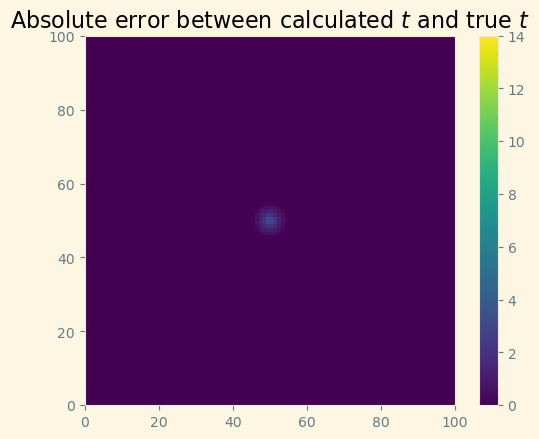

In [ ]:
# Create cubic interpolation
cs = CubicSpline(LUT[:, 0], LUT[:, 1])

# Plot function to be inverted
fig, ax = plt.subplots()
ax.plot(LUT[:, 0], LUT[:, 1])
ax.set_xlabel('Values')
ax.set_ylabel('Corresponding $t$ value')
ax.set_title('Interpolated function')

# Calculate for desired values
t_calc = cs(y.flatten())
t_calc = t_calc.reshape(100, 100)

# Plot calculated t values
fig, axs = plt.subplots(1, 2)
pos = axs[0].pcolormesh(t_calc)
axs[0].set_title('Calculated $t$ values')
axs[0].set_aspect('equal')

# Plot true t values
pos = axs[1].pcolormesh(t)
axs[1].set_title('True $t$ values')
axs[1].set_aspect('equal')
cax = axs[1].inset_axes([1.05, 0, 0.1, 1])
fig.colorbar(pos, ax=axs[1], cax=cax)

# Plot difference image
t_diff = abs(t - t_calc)
fig, ax = plt.subplots()
pos = ax.pcolormesh(t_diff, vmin=0, vmax=14)
ax.set_title('Absolute error between calculated $t$ and true $t$')
ax.set_aspect('equal')
fig.colorbar(pos)

# Calculate RMSE
t_lin = t.flatten()
t_calc_lin = t_calc.flatten()
RMSE = mean_squared_error(t_lin, t_calc_lin, squared=False)
print(f'{RMSE=}')